# **Market Basket Analysis - Parte 2** 

---

<a href="https://midoritoyota.netlify.app/" target="_blank"><img align="left" src="portfolio.png" title="See my portfolio!"/></a><img align="left" src="espaco.png"/>

<a href="mailto:midori.toyota@gmail.com" target="_blank"><img align="left" src="gmail.png" title="Contact me!"/></a><img align="left" src="espaco.png"/>

<a href="https://www.linkedin.com/in/midoritoyota/" target="_blank"> <img align="left" src="linkedin.png" title="Add me on linkedin!" /></a><img align="left" src="espaco.png"/>

<a href="https://github.com/MidoriToyota" target="_blank"> <img align="left" src="github.png" title="Follow me on github!"/></a>

<br/><br/>

## **Definição do problema**

Esta é a parte 2 (análise exploratória com o algorítimo APRIORI) de um dos projetos de conclusão do módulo Business Analytics da Formação Cientista de Dados da Data Science Academy (DSA)

Nessa primeira fase farei a análise exploratória dos dados de um aplicativo de compras para entender o perfil de compra dos usuários.

“The Instacart Online Grocery Shopping Dataset 2017”, Accessed from: 

https://www.instacart.com/datasets/grocery-shopping-2017 on 25/05/2020.

Post do VP da Instacart definindo o problema em detalhes:

https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2?gi=41f7b19cd164


## **Pacotes e dados**


Utilizarei o pacole arules, que cria as regras segundo o algorítimo APRIORI, o pacote arulesViz, que permite a visualização de objetos da classe transaction.

In [ ]:
# Carregando pacotes
library("arules")
library("arulesViz")
library("tidyverse")
library("knitr")
library("lubridate")
library("plyr")
library("RColorBrewer")
library("repr")
library("sqldf")
library("treemap")

In [2]:
# Carregado datasets
orders = read.csv("data/orders.csv", sep = ",")
products = read.csv("data/products.csv", sep = ",")
aisles = read.csv("data/aisles.csv", sep = ",")
departments = read.csv("data/departments.csv", sep = ",")
train = read.csv("data/order_products__train.csv", sep = ",")

## **Pré Processamento**

In [137]:
# Inserir o nome do produto nos dados de treino
data = merge(train, products, by = "product_id")

# Remover colunas desnecessárias
data = subset(data, select = -c(product_id, reordered, aisle_id, department_id))

# Trasnformar factors em characters
data$product_name = as.character(data$product_name)

# Remover vírgulas e ponto e vírgula do nome dos itens (se houver)
data$product_name = gsub(',', '-', data$product_name) 
data$product_name = gsub(';', '-', data$product_name)

# Colocando itens em ordem de compra (importante não deixar em ordem aleatória!)
data = data[order(data$order_id, data$add_to_cart_order),]

head(data)

,order_id,add_to_cart_order,product_name
,<int>,<int>,<chr>
1375140,1,1,Bulgarian Yogurt
277448,1,2,Organic 4% Milk Fat Whole Milk Cottage Cheese
257146,1,3,Organic Celery Hearts
1383168,1,4,Cucumber Kirby
1194905,1,5,Lightly Smoked Sardines in Olive Oil
331856,1,6,Bag of Organic Bananas


In [139]:
# Agrupar os dados por Order id e colapsar produtos
transacoes = ddply(data, "order_id", function(order) paste(order$product_name, collapse = ","))
                   
# Remover coluna order_id (só usada para agrupar)                   
transacoes$order_id = NULL
head(transacoes)

,V1
,<chr>
1,"Bulgarian Yogurt,Organic 4% Milk Fat Whole Milk Cottage Cheese,Organic Celery Hearts,Cucumber Kirby,Lightly Smoked Sardines in Olive Oil,Bag of Organic Bananas,Organic Hass Avocado,Organic Whole String Cheese"
2,"Grated Pecorino Romano Cheese,Spring Water,Organic Half & Half,Super Greens Salad,Cage Free Extra Large Grade AA Eggs,Prosciutto- Americano,Organic Garnet Sweet Potato (Yam),Asparagus"
3,"Shelled Pistachios,Organic Biologique Limes,Organic Raw Unfiltered Apple Cider Vinegar,Organic Baby Arugula,Organic Hot House Tomato,Green Peas,Bunched Cilantro,Flat Parsley- Bunch,Fresh Dill"
4,"Roasted Turkey,Organic Cucumber,Organic Grape Tomatoes,Organic Pomegranate Kernels,Organic Raspberries,Organic Whole Strawberries,Organic Blueberries"
5,"Natural Spring Water,Organic Orange Juice With Calcium & Vitamin D,Whole Milk Greek Blended Vanilla Bean Yogurt,Bag of Organic Bananas,Organic Chocolate Almondmilk Pudding,Organic Sliced Provalone Cheese,Tomatoes- Crushed- Organic,Organic Unsweetened Almond Milk,Crackers- Oyster,Uncured Applewood Smoked Bacon,Organic Seasoned Yukon Select Potatoes Hashed Browns,Organic Extra Virgin Oil Olive,Organic Raspberries,Unsalted Cultured Butter,Guacamole,Black Beans,Raspberry Sorbet Pops,Geranium Liquid Dish Soap,Baby Swiss Slices Cheese,Organic Whole Grassmilk Milk,Organic Raw Kombucha Gingerade,Organic Hothouse Cucumbers,Black Beans No Salt Added,Organic Cinnamon Apple Sauce,Uncured Genoa Salami,Queso Fresco,Natural Chicken & Maple Breakfast Sausage Patty,Sliced Pepperoni,Organic Garlic,100% Organic Unbleached All-Purpose Flour,Lavender Scent Laundry Detergent,Organic Italian Parsley Bunch,Organic 2% Buttermilk,Organic Yellow Onion,Organic Free Range Chicken Broth,Organic Stringles Mozzarella String Cheese,Garbanzo Beans,Organic Ketchup,Organic Zucchini,Mild Diced Green Chiles,Pinto Beans No Salt Added,Organic Lemonade,Corn Maize Tortillas,Organic Corn Starch,Olive Oil & Aloe Vera Hand Soap,Plastic Spoons,Aluminum Foil,Plastic Wrap,Organic Coconut Milk"
6,"Fresh Cauliflower,I Heart Baby Kale,Sea Salt Baked Potato Chips,Marinara Pasta Sauce,Organic Hass Avocado,Organic Lemon,Coconut Water Kefir,Premium Epsom Salt,Umcka Elderberry Intensive Cold + Flu Berry Flavor,Hickory Honey Barbeque Baked Potato Chips,Baked Sea Salt & Vinegar Potato Chips"


In [ ]:
# Transformar itens para formato "transactions" (arquivo próprio do algorítimo)
write.csv(transacoes,"./data/transacoes.csv", quote = FALSE, row.names = FALSE)
data_trans = read.transactions('./data/transacoes.csv', format = 'basket', sep=',')

# Classe do objeto
class(data_trans)

In [141]:
backup = data_trans

## **Objetos de classe transactions**

O pacote APRIORI lê um tipo diferente de arquivo. O arquivo é da classe transactions, e não dá para visualizar com head, pois não é um dataframe nem uma matriz. O arquivo se assemelha à uma lista de dataframes.

**Comando inspect**

O comando `inspect` pertence ao pacote arulesViz e é uma forma de visualizar o conteúdo de um objeto da classe transactions. Abaixo, vemos a aplicação do comando `inspect`, que mostra um índice identificador da ordem de compra e dentro de cada ordem de compra há uma lista de itens comprados, como se fossem os itens de um cupom fiscal. Lembre-se de utilizar o comando `head` antes de utilizar o inspect nos dados!

In [142]:
inspect(head(data_trans,3))

    items                                          
[1] {V1}                                           
[2] {Bag of Organic Bananas,                       
     Bulgarian Yogurt,                             
     Cucumber Kirby,                               
     Lightly Smoked Sardines in Olive Oil,         
     Organic 4% Milk Fat Whole Milk Cottage Cheese,
     Organic Celery Hearts,                        
     Organic Hass Avocado,                         
     Organic Whole String Cheese}                  
[3] {Asparagus,                                    
     Cage Free Extra Large Grade AA Eggs,          
     Grated Pecorino Romano Cheese,                
     Organic Garnet Sweet Potato (Yam),            
     Organic Half & Half,                          
     Prosciutto- Americano,                        
     Spring Water,                                 
     Super Greens Salad}                           


**Estrutura da classe transaction**

O objeto da classe transaction é dividido em 3 componentes `@data`, `@itemInfo` e `@itemsetInfo`:

- O `@data` é uma matriz que contém 2 listas: data_trans@data@i (lista completa dos itens comprados do primeiro ao último cliente, por código do produto) e data_trans@data@p (lista com os índices que dividem uma compra de outra). Dim e Dinames são apenas informações sobre a natureza do objeto.
- O `@itemInfo` é um dataframe com os labels (que tem o nome de cada produto).
- O `@itemsetInfo` é uma dataframe vazio que só será preenchido quando rodarmos a função apriori


In [143]:
# Estrutura da Classe transaction
str(data_trans)

Formal class 'transactions' [package "arules"] with 3 slots
  ..@ data       :Formal class 'ngCMatrix' [package "Matrix"] with 5 slots
  .. .. ..@ i       : int [1:1297002] 46503 3212 5441 11429 22400 27774 28410 31007 33280 2854 ...
  .. .. ..@ p       : int [1:131211] 0 1 9 17 26 33 82 93 110 115 ...
  .. .. ..@ Dim     : int [1:2] 48927 131210
  .. .. ..@ Dimnames:List of 2
  .. .. .. ..$ : NULL
  .. .. .. ..$ : NULL
  .. .. ..@ factors : list()
  ..@ itemInfo   :'data.frame':	48927 obs. of  1 variable:
  .. ..$ labels: chr [1:48927] "#2 Coffee Filters" "#2 Cone White Coffee Filters" "#2 Mechanical Pencils" "#4 Natural Brown Coffee Filters" ...
  ..@ itemsetInfo:'data.frame':	0 obs. of  0 variables


In [144]:
# Resumo do arquivo
summary(data_trans)

transactions as itemMatrix in sparse format with
 131210 rows (elements/itemsets/transactions) and
 48927 columns (items) and a density of 2e-04 

most frequent items:
                Banana Bag of Organic Bananas   Organic Strawberries 
                 18154                  15054                  10337 
  Organic Baby Spinach            Large Lemon                (Other) 
                  9395                   7794                1236268 

element (itemset/transaction) length distribution:
sizes
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
7799 8237 8773 8771 9342 9083 8690 8119 7239 6525 5949 5249 4654 4215 3617 3320 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
2894 2518 2283 1919 1675 1475 1289 1115  942  821  711  546  534  436  373  325 
  33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48 
 263  233  220  143  140  127  105   69   64   62   47   55   36   31   31   19 
  49   5

O resumo acima nos dá algumas informações:

- Temos um total de 131210 transações e 50052 tipos de produtos
- A matriz gerada é esparça, ou seja, em sua maior parte está vazia.
- O item mais comum vendido é a banana seguida de bag of organic bananas.
- Em média, as pessoas fazem compras de 8 itens e a maior compra foi de 84 itens de uma só vez.

**Itens mais frequentes**

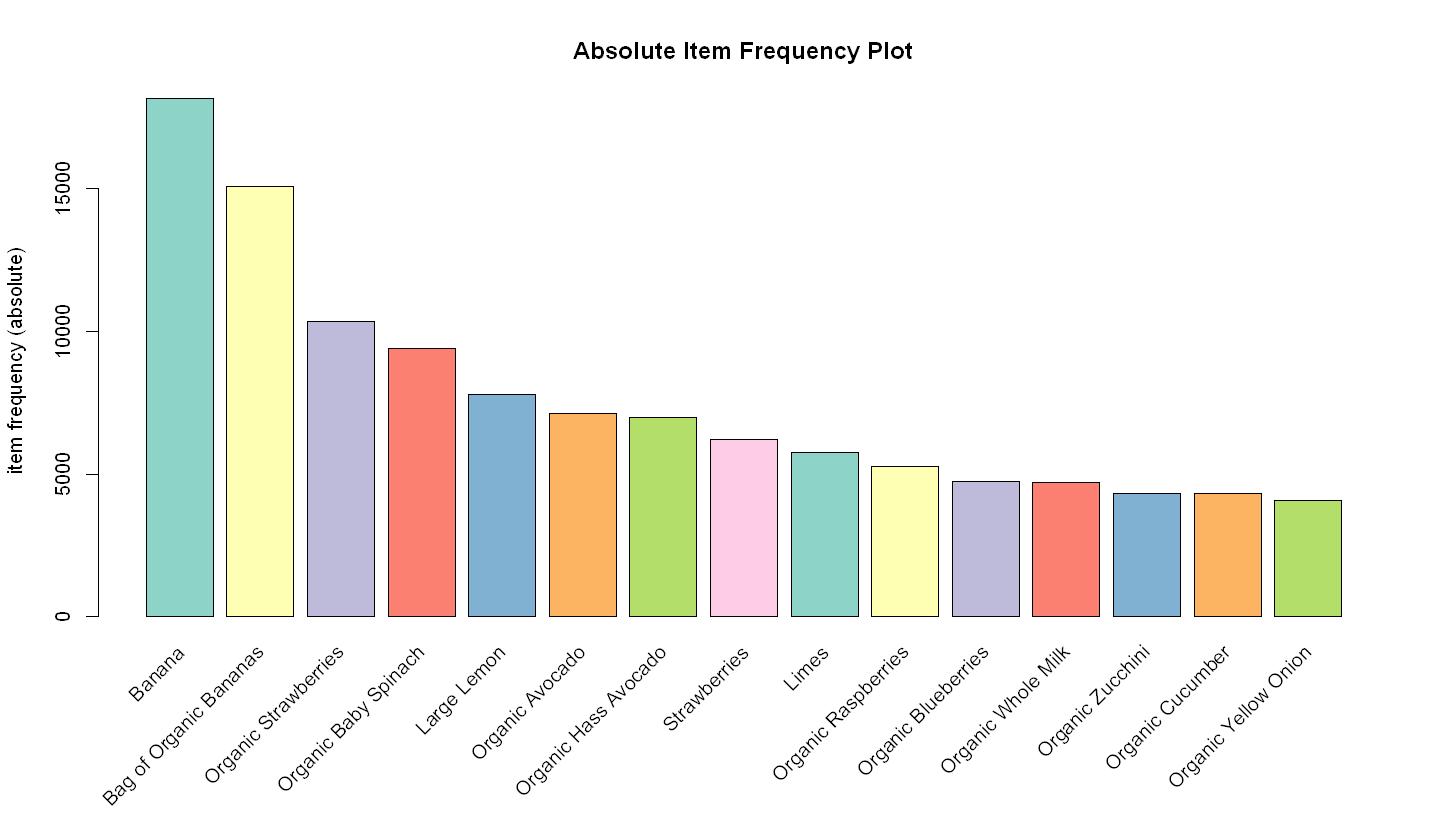

In [145]:
# Plot dos itens mais frequentemente comprados
options(repr.plot.width=12, repr.plot.height=7)
itemFrequencyPlot(data_trans, topN=15, type="absolute", col=brewer.pal(8,'Set3'), main="Absolute Item Frequency Plot")

## **Criando Regras**


Para criar regras é necessários definir 2 parâmetros:

- support (`supp`) : é o quanto um determinado set de compras apareceu na nossa amostra (em porcentagem)
- confidence (`conf`) : é o quanto a regra aconteceu em todas as vezes que ela podia ter acontecido.

O `maxlen` é opcional. Colocamos para evitar regras muito longas.

In [200]:
# Criando regras 
rules = apriori(data_trans, parameter = list(supp=0.0001, conf=0.80, maxlen=4))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.8    0.1    1 none FALSE            TRUE       5   1e-04      1
 maxlen target  ext
      4  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 13 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[48927 item(s), 131210 transaction(s)] done [0.76s].
sorting and recoding items ... [10802 item(s)] done [0.03s].
creating transaction tree ... done [0.09s].
checking subsets of size 1 2 3 4

Warning message in apriori(data_trans, parameter = list(supp = 1e-04, conf = 0.8, :
"Mining stopped (maxlen reached). Only patterns up to a length of 4 returned!"


 done [1.05s].
writing ... [40 rule(s)] done [0.20s].
creating S4 object  ... done [0.06s].


In [201]:
# Visualizar as 10 primeiras regras
options(digits=2)
rules = sort(rules, by="confidence", decreasing=TRUE)
inspect(rules[1:10])

     lhs                                               rhs                                           support confidence coverage  lift count
[1]  {Low-Fat Mango on the Bottom Greek Yogurt,                                                                                             
      Peach on the Bottom Nonfat Greek Yogurt,                                                                                              
      Strawberry on the Bottom Nonfat Greek Yogurt} => {Blueberry on the Bottom Nonfat Greek Yogurt} 0.00012       0.94  0.00013 614.4    16
[2]  {Cran Raspberry Sparkling Water,                                                                                                       
      Peach Pear Flavored Sparkling Water,                                                                                                  
      Sparkling Water Berry}                        => {Sparkling Water Grapefruit}                  0.00011       0.94  0.00012  38.0    15
[3]  {Lime Sp

Foram criadas as regras acima que mostram o que as pessoas costumam comprar costumam comprar em um mesmo pedido, antes e depois. 

Na análise exploratória da parte 1, vimos que existe uma variedade enorme de alimentos não saudáveis como chocolates e sorvetes. Percebemos, porém, que os itens mais comprados são os saudáveis. Talvez isso ocorra porque como temos uma variedade enorme de tipos de sorvete, o volume de compras se dilui nos diversos tipos de sorvete. Agora, se for para comprar bananas só tem Bananas e Bag of organic bananas. Podemos confirmar essa hitpótese mais tarde.

Com s regras criadas podemos responder a duas perguntas principais:

**People who bought Blueberry, also bought...**

In [174]:
# Criação de regra para o item Blueberry (lhs = Blueberry)

blueberry_rules = apriori(data_trans, parameter = list(supp=0.0001, conf=0.50), appearance = list(lhs="Blueberry", default="rhs"), control = list(verbose=F))
inspect(blueberry_rules)

    lhs            rhs      support confidence coverage lift count
[1] {Blueberry} => {Banana} 0.00021 0.6        0.00036  4.3  28   


Quem compra Blueberry compra também... BANANA Claro! Todos compram bananas nesse dataset rsrs

Também podemos fazer da maneira inversa:

**Before buying Organic Strawberries, people bought...**

In [181]:
# Criação da regra para o item METAL (rhs = Organic Strawberries)
strawberry_rules = apriori(data_trans, parameter = list(supp=0.0001, conf=0.80), appearance = list(rhs="Organic Strawberries", default="lhs"), control = list(verbose=F))
inspect(strawberry_rules)

    lhs                                 rhs                    support confidence coverage lift count
[1] {Backyard Barbeque Potato Chips,                                                                 
     Organic Raspberries}            => {Organic Strawberries} 0.00011       0.88  0.00012   11    14
[2] {Bag of Organic Bananas,                                                                         
     Organic Garlic,                                                                                 
     Organic Kiwi,                                                                                   
     Organic Raspberries}            => {Organic Strawberries} 0.00012       0.80  0.00015   10    16


Backyard Barbeque Potato Chips, um pouco de comida não saudável, finalmente!

## **Plotagens**


### **Pacote AruleViz**

O pacote ArulesViz permite fazer alguns plots especificamente para visualizarmos as regras criadas. Vejamos algumas:

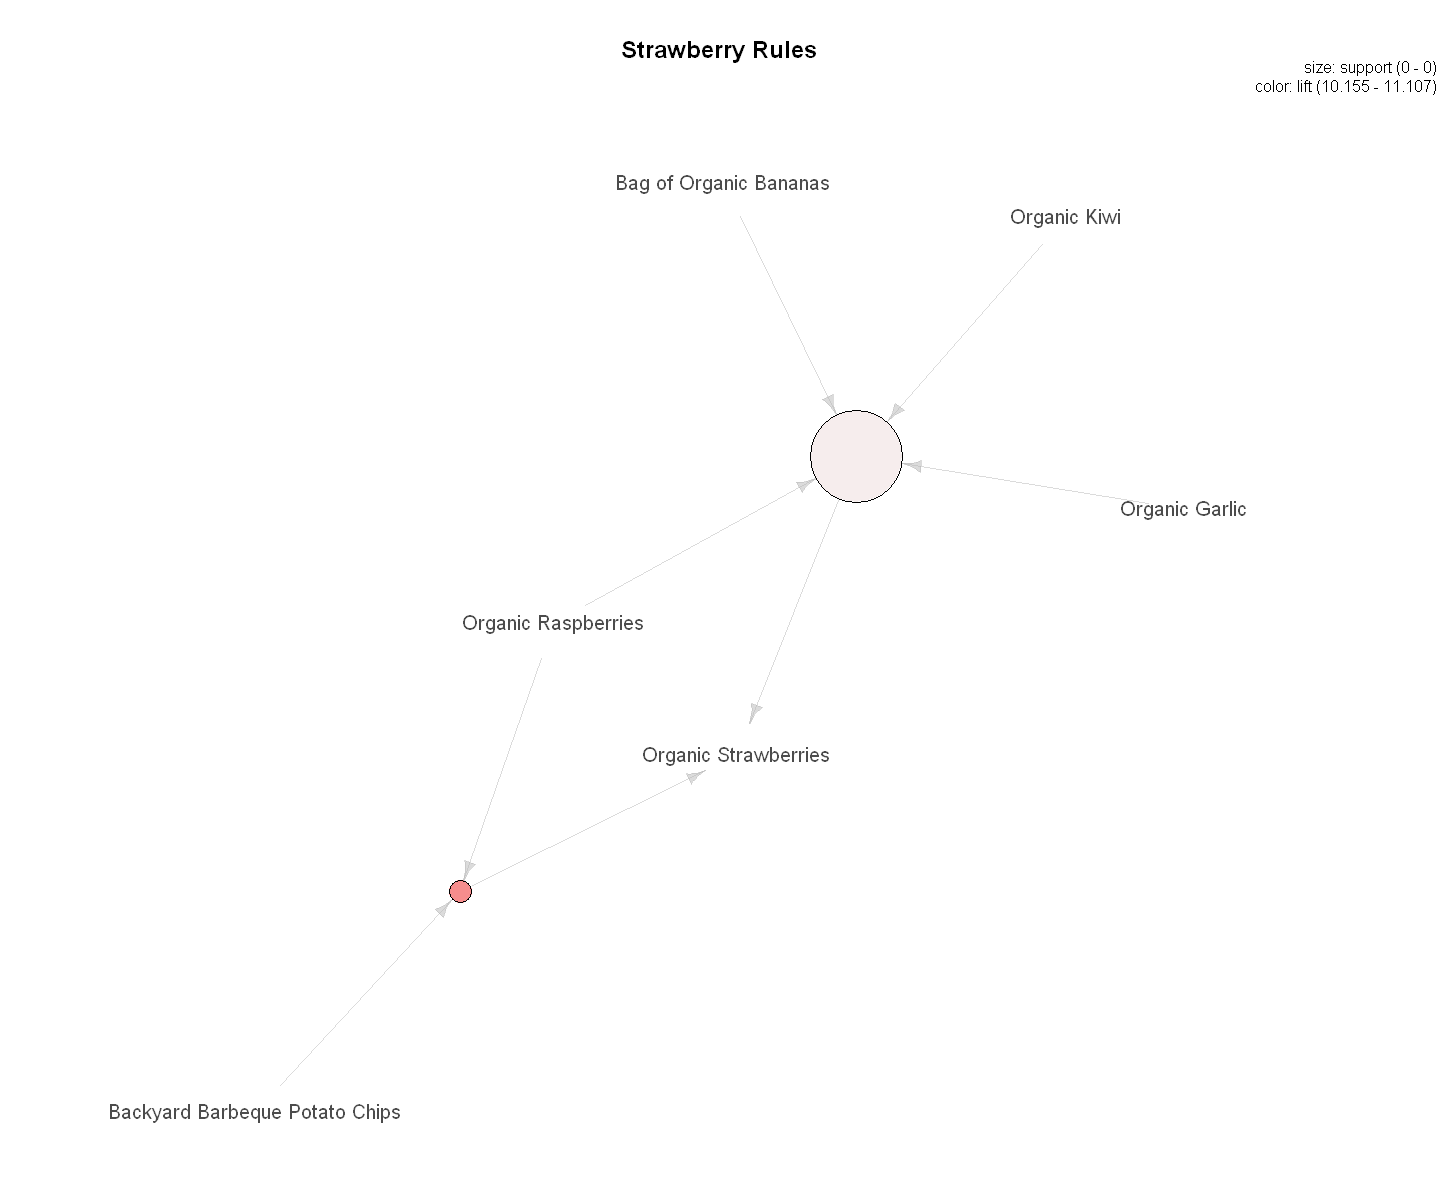

In [208]:
# Plot default
options(repr.plot.width=12, repr.plot.height=10)
plot(strawberry_rules, method="graph", engine = "default", main = "Strawberry Rules")

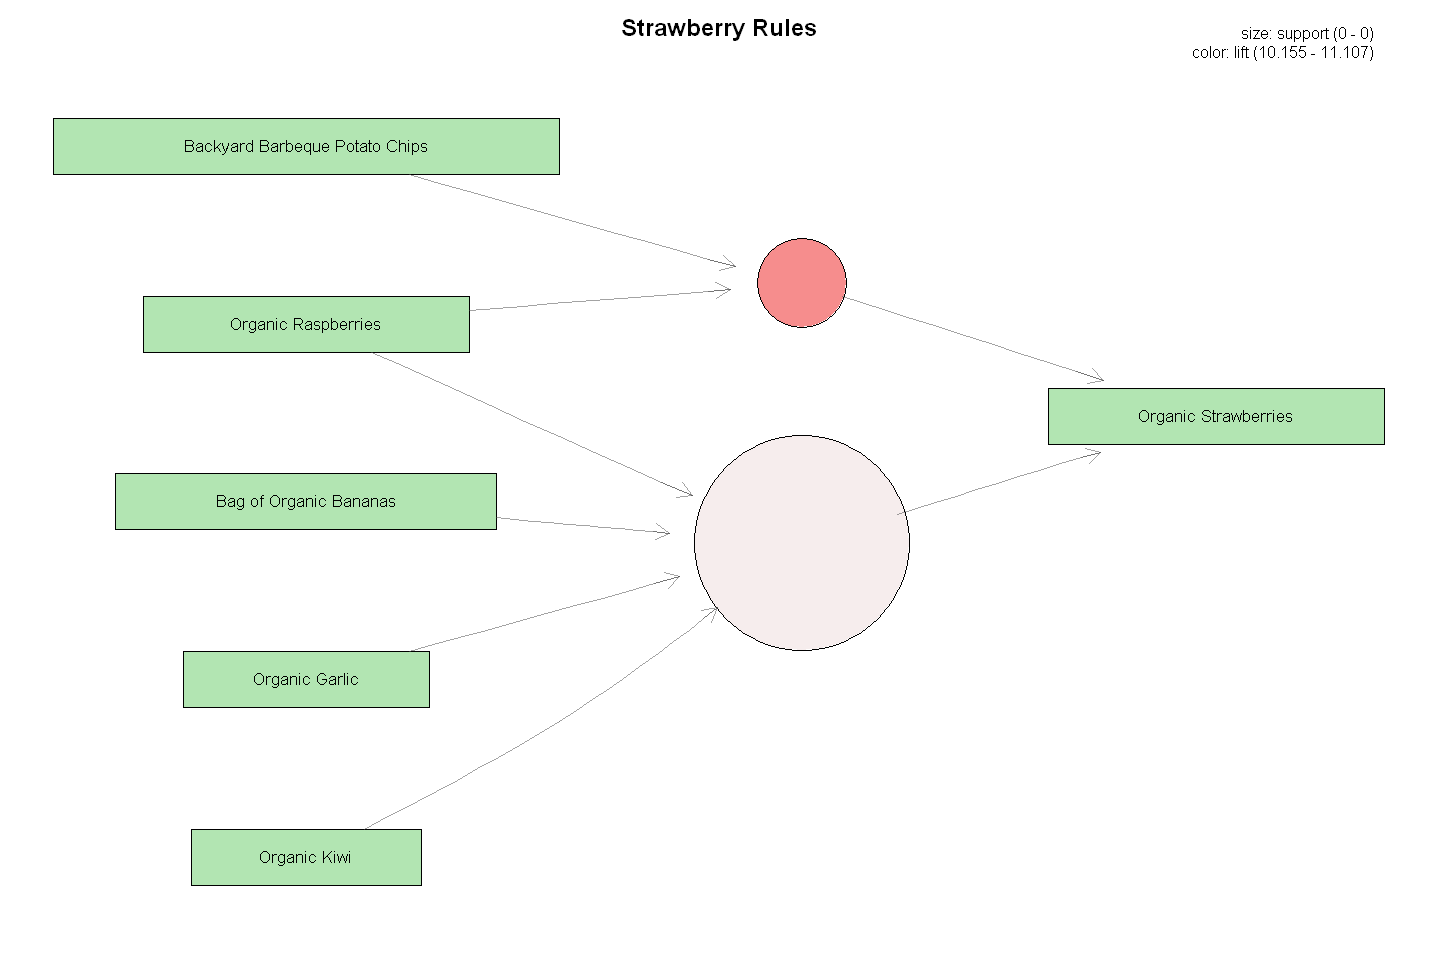

In [209]:
# Plot com Engine Graphviz
options(repr.plot.width=12, repr.plot.height=8)
plot(strawberry_rules, method="graph", engine = "graphviz", main = "Strawberry Rules")

O plot mais legal é com o `engine` = "interactive" pois cria um gráfico interativo onde você pode selecionar os itens com o mouse, porém, ele é aberto em uma janela fora do jupyter-notebook, então não inseri aqui mas fica a dica.

### **Categorias mais compradas**

In [210]:
# Inserir o nome do produto nos dados de treino
data2 = merge(train, products, by = "product_id")
data2 = merge(data2, aisles, by = "aisle_id")
data2 = merge(data2, departments, by = "department_id")

head(data2)

,department_id,aisle_id,product_id,order_id,add_to_cart_order,reordered,product_name,aisle,department
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>
1,1,37,25745,494894,9,0,Oreo Ice Cream Sandwiches,ice cream ice,frozen
2,1,37,2361,1934814,3,0,Mint Chip,ice cream ice,frozen
3,1,37,17334,2448852,6,1,Coffee Ice Cream,ice cream ice,frozen
4,1,37,34329,122214,4,1,Belgian Milk Chocolate Gelato,ice cream ice,frozen
5,1,37,28281,970060,1,0,Variety Pack Ice Cream Bars,ice cream ice,frozen
6,1,52,162,2684253,6,1,Organic Mini Homestyle Waffles,frozen breakfast,frozen


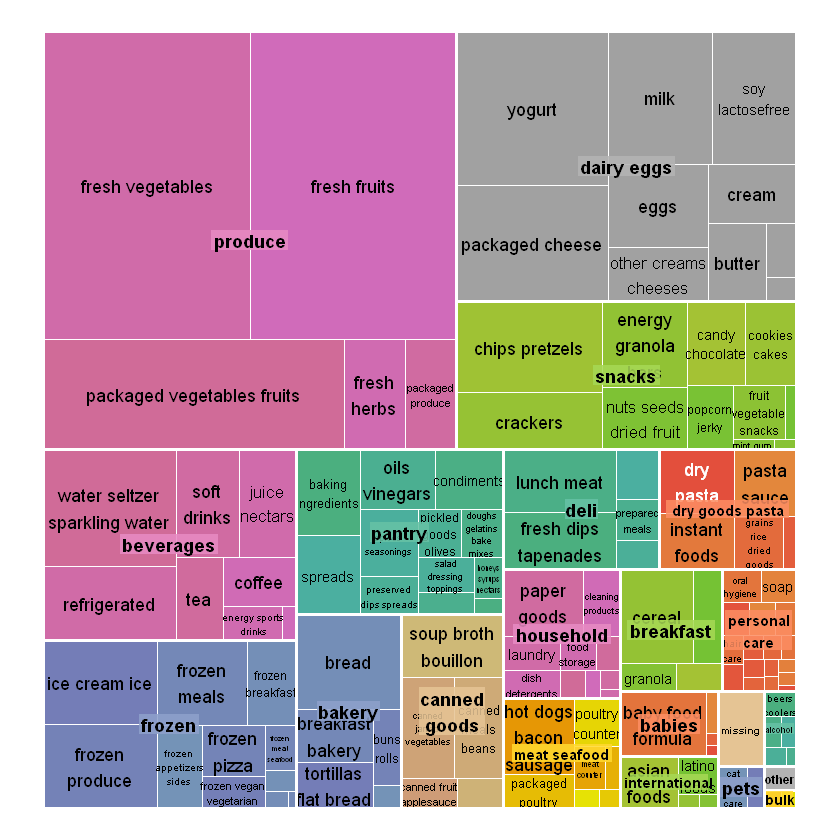

In [226]:
# Preparo dos dados para visualização do treemap
options(repr.plot.width=7, repr.plot.height=7)


tmp = sqldf( " SELECT department, aisle, COUNT(product_id) AS n_products
               FROM data2 
               GROUP BY department, aisle " )

# Plot treemap
treemap(tmp,index=c("department","aisle"),vSize="n_products",palette="Set2",border.col="#FFFFFF", title = "")

Pelo treemap acima, percebemos que a teorida de que *mais alimentos industrializados estão sendo comprados porém como eles estão vidividos em produtos diferentes (diferentes tipos de sorvete etc), eles não aparecem nos produtos mais vendidos* não está correta, pode ser em parte verdade, mas, alimentos como verduras e frutas frescas ainda são as mais compradas.

## **Conclusão**

O APRIORI é um ótimo algorítimo para ser usado na análise exploratória. Ele dá um panorama bom do padrão de consumo dos clientes e é possível obter insights para melhorar as recomendações ao usuário ou melhorar a proximidade das categorias. Utilize-o à seu favor!

---

<a href="https://midoritoyota.netlify.app/" target="_blank"><img align="left" src="portfolio.png" title="See my portfolio!"/></a><img align="left" src="espaco.png"/>

<a href="mailto:midori.toyota@gmail.com" target="_blank"><img align="left" src="gmail.png" title="Contact me!"/></a><img align="left" src="espaco.png"/>

<a href="https://www.linkedin.com/in/midoritoyota/" target="_blank"> <img align="left" src="linkedin.png" title="Add me on linkedin!" /></a><img align="left" src="espaco.png"/>

<a href="https://github.com/MidoriToyota" target="_blank"> <img align="left" src="github.png" title="Follow me on github!"/></a>

<br/><br/>